## Task 2

forecasting_dataset.csv is a file that contains pollution data for a city. Your task is to create a model that, when fed with columns co_gt, nhmc, c6h6, s2, nox, s3, no2, s4, s5, t, rh, ah, and level, predicts the value of y six hours later.

In [85]:
# basic bitches
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn

# model
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve, accuracy_score

# for pipeline
from src.task1.keras_model import keras_model
from sklearn.pipeline import Pipeline

# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
df = pd.read_csv("../../data/forecasting_dataset.csv")
df.shape

(8421, 16)

In [3]:
df.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,10/13/2004,20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN
1,8/10/2004,3:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low
2,6/21/2004,8:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High
3,7/12/2004,12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High
4,12/14/2004,12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High


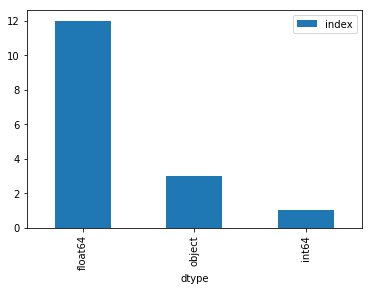

In [87]:
pd.DataFrame(df.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count().sort_values('index', ascending=False).plot(kind='bar')

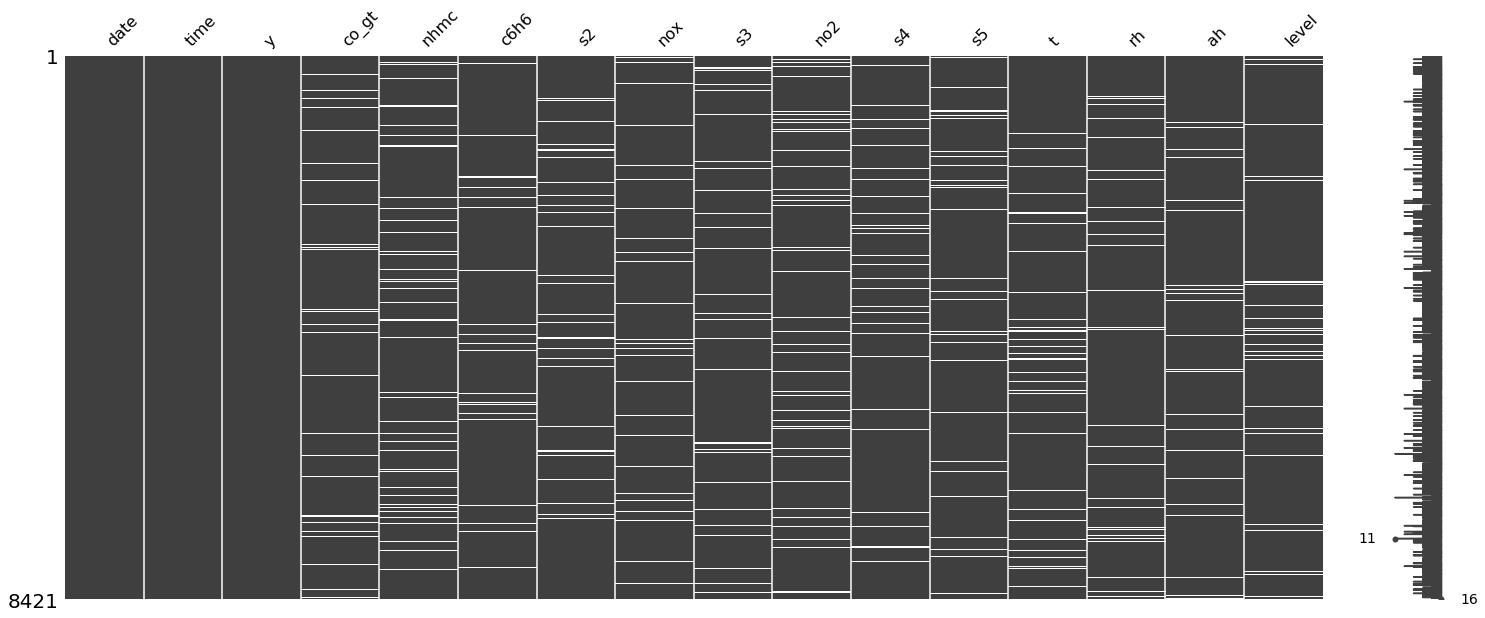

In [7]:
msn.matrix(df)

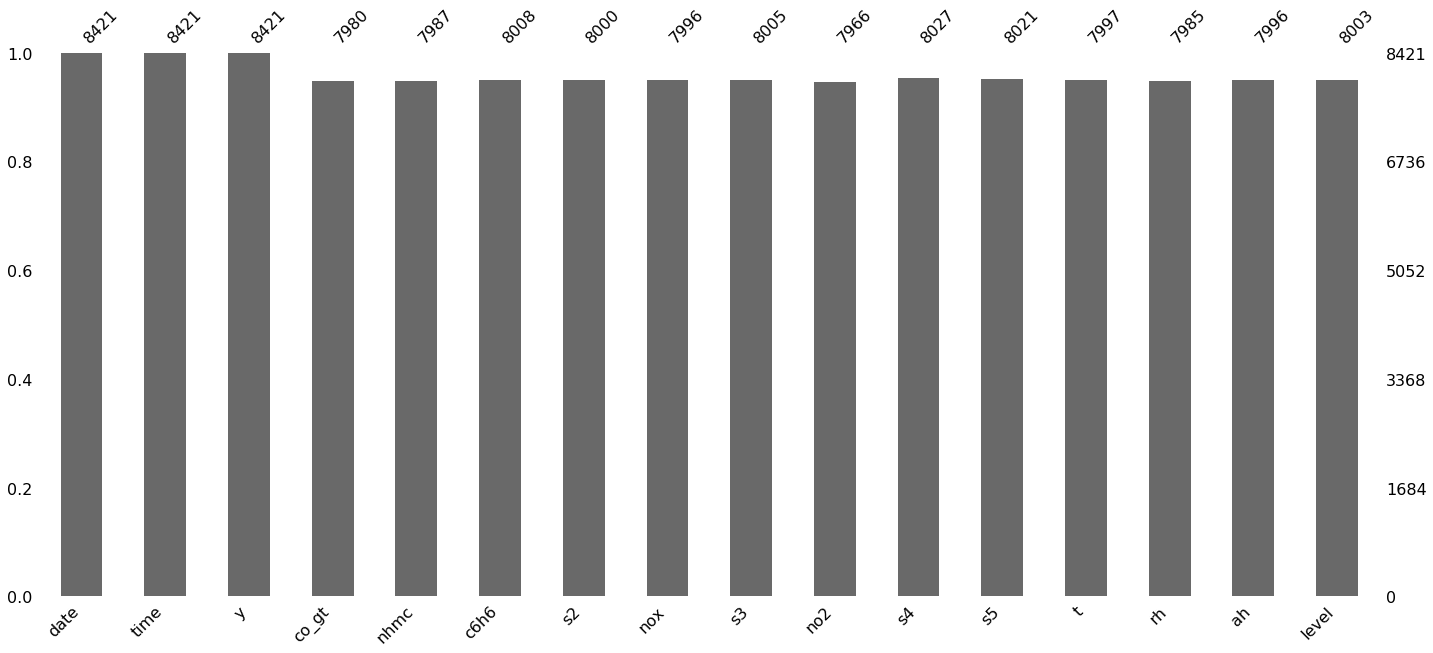

In [9]:
msn.bar(df)

In [23]:
# Time 
pollution = df.sort_values("y")

# Refactor the time_stamp column to datetime object
pollution["date"] = pd.to_datetime(df["date"])
pollution["time"] = pd.to_datetime(df["time"], format= '%H:%M:%S' ).dt.time

pollution = pollution.sort_values(["date","time"])

# Reset index
pollution = pollution.reset_index().iloc[:,1:29]
pollution.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10,18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10,19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10,20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10,21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10,22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


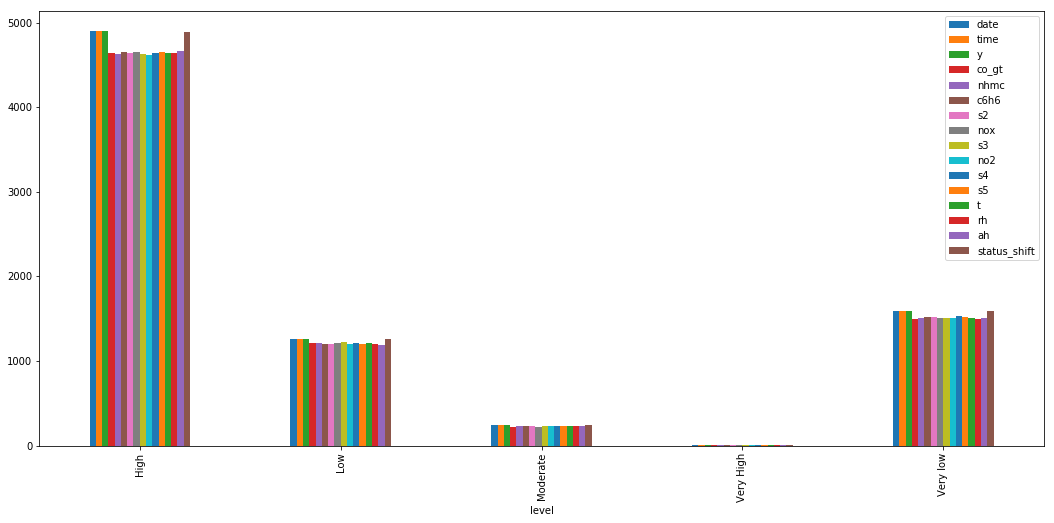

In [81]:
# Distribution of different levels of categorical variables:
fig, ax = plt.subplots(figsize=(18,8))
pollution.groupby('level').count().plot(kind='bar', ax=ax)

In [88]:
# Create column contains value of 6 hours later:
pollution["y_shift"] = pollution[['time','y']]['y'].transform(lambda g: g.shift(periods=-6))

In [89]:
pollution[['date','time','y',"y_shift"]].head()

,date,time,y,y_shift
0,2004-03-10,18:00:00,1360,1185.0
1,2004-03-10,19:00:00,1292,1136.0
2,2004-03-10,20:00:00,1402,1094.0
3,2004-03-10,21:00:00,1376,1010.0
4,2004-03-10,22:00:00,1272,1011.0


In [98]:
total_obs

8421

In [99]:
X.shape[0]

8421

In [90]:
# Create a list of features needed
X_col = [ i for i in pollution.columns if i not in ['date', 'time', 'y_shift', 'y']]

In [68]:
# Create X, y
X = pollution[X_col]
y = pollution["y_shift"] # keeping time_stamp to split train test validation

In [ ]:
get_dummies(X['level'])

In [69]:
# Split Train, Test, Validation set
total_obs = len(X['s2'])
thred = int(total_obs*0.1)
# For X
Xval = X[total_obs-thred:total_obs]
Xtest = X[total_obs-thred*2:total_obs-thred]
Xtrain = X[:total_obs-thred*2]

# For y:
yval = y[total_obs-thred:total_obs]
ytest = y[total_obs-thred*2:total_obs-thred]
ytrain = y[:total_obs-thred*2]

In [75]:
# Fitting several models to find which one would be good:
# nn = keras_model(n_layers=1, n_feats=Xtrain_res.shape[1])

model_list = {"Logistic Regression": LR(),
              "Random Forest Classifier": RFC(),
              "K Nearest Neighbor": KNN(),
              "Neural Network": keras_model(n_layers=1, n_feats=Xtrain.shape[1])
             }

for k, v in model_list.items():
    print("Fitting {} model...".format(k))
    v.fit(Xtrain, ytrain)
    print("Train accuracy is:", accuracy_score(ytrain_res, v.predict(Xtrain)).round(3))
    ypred = v.predict(Xtest)
    print("Test accuracy is:", accuracy_score(ytest, ypred).round(3))
    print("Confusion Maxtric for {} model".format(k))
    skplt.metrics.plot_confusion_matrix(ytest, ypred)
    plt.show()

Fitting Logistic Regression model...


ValueError: could not convert string to float: 'High'

True

In [ ]:
# Creating a pipeline:
pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('dataframemapper', DataFrameMapper('operational_setting_3', get_dummies, input_df=True)),
        ('model', model)
    ])

In [ ]:
# Fitting the pipeline
pl.fit(Xtrain, ytrain)